# Climate Risk Analysis: Mongolia Dzud and Summer Drought Analysis 2009-2010

## Introduction

Mongolia is highly vulnerable to climate extremes due to its cold continental climate and strong dependence on pastoral livestock subsistence farming. One of the most severe climate hazards affecting the country is *dzud*, a compound winter disaster of varying types, usually characterised by extreme cold, long term or deep snow cover, and ice crusts that prevent livestock from accessing pasture and damage or make infrastructure unusable. Dzud can lead to major livestock losses, threatening rural subsistence farmers and national level food security, further increasing urban struggles with overcrowding and over worked services.

**Types of dzud**
- **White Dzud**: Deep snow covers the ground, burying grass and infrastructure.
- **Black Dzud**: Little persistent snow combined with poor rainfall in the summer, causing little grass on the pastures.
- **Iron dzud**: Icy impenetrable crust forms over the ground, making grass impossible to access.

The 2009-2010 dzud stands out as one of the worst climate disasters in Mongolia's modern history, resulting in the loss of many millions of liverstock and serious socio economic impacts across the entire country. Importantly, dzud risk deos not arise from the winter alone. A summer of poor pasture growth, typically caused by below average rainfall or drought, can leave livestock in a more precarious position going into winter amplifying the potential extremes of the winter.

This notebook analyses the 2009-2010 dzud as a *compound climate event*, starting in the summer 2009 and its precipitation conditions and finishing in the extreme winter spanning 2009-2010. By analysing both phases together, this analysis aims to show the full climatic pathway through which the risk appeared in Mongolia during this period.

**Objectives**
- Assess the precipitation levels and spread in the 2009 summer as a preconditioning factor in dzud risk using satellite rainfall data.  
- Demonstrate the severity of the winter conditions in 2009 and 2010 using temperature and snow related indicators.  
- Compare how the summer and winter of 2009-2010 conditions are against the historical baseline to determine their extremes.    
- Examine spatial patterns of climate stress in Mongolia and illustrate local conditions using Ulaanbaatar as a representative location.  
- Provide a seasonal and compound perspective on climate risk that later supports a comparison with the drought and extreme rainfall risk in Chad.

## Data Sources

This analysis combines both satellite data and reanalysis data to capture the different climatic drivers of dzud risk across seasons and years. Summer conditions, especially those of the pastures and rural areas, are going to be analysed using precipitation data, while winter severity for dzud using temperature and snow variables.

### Primary Sources

**ERA5 Reanalysis (ECMWF)**    
- *Variables*: 
    - 2m air temperature  
    - Snow depth (and/or cover)  
- *Spatial resolution*:     
    - ERA5: ~0.25° x 0.25°  
- *Temporal resolution*:
    - Hourly, being aggregated to daily for this analysis
- *Coverage*:
    - Global
- *Usage in this notebook*:
    - Assessment of the winter severity during 2009-10 dzud
    - Historical baseline comparison of winter conditions
- *Source*:
    - https://cds.climate.copernicus.eu/datasets/

**CHIRPS (Climate Hazards Group InfraRed precipitation with Station Data)**
- *Variables*: 
    - Daily Precipitation
- *Spatial resolution*:  
    - ~0.25° x 0.25°     
- *Temporal resolution*:
    - Daily
- *Coverage*:
    - Global, 1981-Current
- *Usage in this notebook*:
    - Assessment of the summer precipitation conditions (June-October 2009)
    - Historical baseline comparison of summer rainfall
- *Source*:
    - https://data.chc.ucsb.edu/products/CHIRPS-2.0/

### Supplementary Sources

**Country Boundaries**:
- Source: Natural Earth (110m cultural vectors)
- URL: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
- Purpose: Spatial clipping and visualization

**MODIS Snow Cover (Potentially)**  
- *Variable*: 
    - Snow cover extent  
- *Spatial resolution*: 
    - ~500 m  
- *Temporal resolution*: 
    - Daily  
- *Usage*:  
    - Qualitative validation of snow persistence patterns  
    - Supplementary visualisation of winter snow conditions  
- *Source*:
    - https://modis.gsfc.nasa.gov/data/dataprod/mod10.php

### Data Notes

- The analysis period spans **June 2009 to March 2010**, capturing both summer preconditioning and winter dzud severity.  
- Historical baseline conditions are derived from **1981–2009**, providing a consistent reference period prior to the 2009–2010 event.    
- All datasets are spatially subset to Mongolia’s national boundaries.  
- Temperature is analysed in degrees Celsius and precipitation in millimeters.  
- Seasonal definitions follow climatological relevance rather than calendar years:
  - **Summer**: June–October
  - **Winter**: November–March
- ERA5 data is installed using cdsapi and an API key. This requires prior configuration of the cdsapi and a valid CDS account.
- MODIS may be used to add further clarity and visualisation of specifically 2009-2010 winter, however due to the nature of the dataset, it may be out of the scope of this notebook
- ERA5 data was swapped from originally ERA5-Land data to ERA5 data due to problems with installing into zip files and not netCDF or grib files.

In [5]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rioxarray
import matplotlib.colors as colors
import cdsapi
import os
import glob
import zipfile

c = cdsapi.Client()

out_dir = r"C:\Projects\geodataprojects\data\mongolia\era5\baseline"
os.makedirs(out_dir, exist_ok=True)

years = range(1981, 2009)
all_exists = True

for year in years:
    outfile = f"{out_dir}/era5_mongolia_winter_{year}.nc"

    if os.path.exists(outfile):
        continue
    else:
        all_exists = False
        print(f"Downloading ERA5 winter data for {year}...")

    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "2m_temperature",
                "snow_depth",
            ],
            "year": str(year),
            "month": ["11", "12", "01", "02", "03"],
            "day": [f"{d:02d}" for d in range(1, 32)],
            "time": "00:00",
            "area": [
                52, 87,   
                41, 120,
            ],
            "format": "netcdf",
            "download_format": "unarchived"
        },
        outfile,
    )

if all_exists == True:
    print("All files are already installed")    

2025-12-30 21:52:07,066 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


All files are already installed


## Historical Baseline Context

To assess the severity of the 2009-2010 dzud, this analysis will establish a historical climatic baseline using temperature data from 1981-2008. This baseline captures the range of temperatures and snow conditions typically experienced during Mongolian winters prior to the analysis period 2009-2010 and provides a reference for which anomalies can be evaluated.

Dzud risk in Mongolia is opposingly different from drought climate hazards observed in other semi arid regions. Rther than being driven by solely annual precipitation, dzud emerges from the interaction of low or non existent rainfall during the needed wet season and the extreme cold, persistent snow cover, and prolonged cold spell that follows in the winter. As such, the historical baseline focusses on winter relevant indicators, including temperature extremes, cold spell persistence, and snow conditions, however total rainfall of the wet season will also be an important metric to view how it differed in the 2009 summer and historically.

### Why 1981-2008?

The period of 1981-2008 is selected as the historical baseline for three key factors.

**Climatological standard**: A 30 year window is widely accepted as the standard reference window for which data of a set period can be historically referenced off of, capturing both the typical variability and the extreme cases.  
**Pre event baseline**: 1981-2008 is selected specifically so that the historical data is prior to the event of analysis of 2009, avoiding contamination of the data by including reference to the dzud itself.  
**Data availability**: While ERA5 includes data from 1940 until present, and as such a more climatologically accurate baseline of 1978-2008 could have been selected, the most that rainfall data from CHIRPs includes is from 1981, and as such it is most accurate to select what is within the scope of the data. This is still a 28 year period, and as such sufficiently accurate for a historic baseline period.

### Statistical References
The historical baseline is used to create reference statistics against which summer and winter conditions during 2009–2010 are evaluated These metrics are chosen to reflect the primary climatic drivers of dzud risk:

**Winter mean temperature**: Characterizes overall thermal severity.  
**Cold spell persistence**: Captures the duration of extreme cold events, which are critical for livestock survival.  
**Snow depth and persistence**: Indicates the extent to which snow cover limits access to forage.  
**Interannual variability**: Provides context for distinguishing extreme events from normal yearly fluctuations.
**Summer mean precipitation**: Shows context for how much rain is normal for pastures in Mongolia.  
**Summer rainfall percentile**: Highlights where the summer of 2009 lies in the baseline distribution.
**Frequency of dry summers**: Provides information as to how frequent dry summers are for Mongolia and their significance to dzud.

Percentile metrics are used selectively to position the 2009–2010 winter within the historical distribution, while persistence metrics
are emphasized where threshold metric approaches are more physically meaningful.

In [11]:
era5_basline_dir = r"C:\Projects\geodataprojects\data\mongolia\era5\baseline"

files = sorted(glob.glob(os.path.join(
    era5_basline_dir,
    "era5_mongolia_winter_*.nc"
)))

ds_era5 = xr.open_mfdataset(
    files,
    combine="by_coords",
    parallel=True,
    chunks={"time": 90}
)

ds_era5 = ds_era5.rename({"valid_time": "time"})

chirps_dir = r"C:\Projects\geodataprojects\data\mongolia\chirps"

chirps_files = sorted(glob.glob(os.path.join(
    chirps_dir,
    "chirps-v2.0.*.days_p25.nc"
)))

ds_chirps = xr.open_mfdataset(
    chirps_files,
    combine="by_coords",
    parallel=True,
    chunks={"time": 365}
)

### Winter Mean  

Mean winter temperature provides a primary measure of thermal severity during Mongolian winters. Prolonged exposure to severe temperatures increases the likelihood of livestock mortality through heightened caloric requirements, frost injuries, and worsened mobility, especially when combined with snow coverage and limited food ability.

For this analysis, winter is defined as **November to March**, showing the period in which cold extremes are most relevant to dzud and problems with grazing. Winter mean temperature is calculated as the area averaged temperature across Mongolia for each winter season during the historic baseline period of 1981-2008.

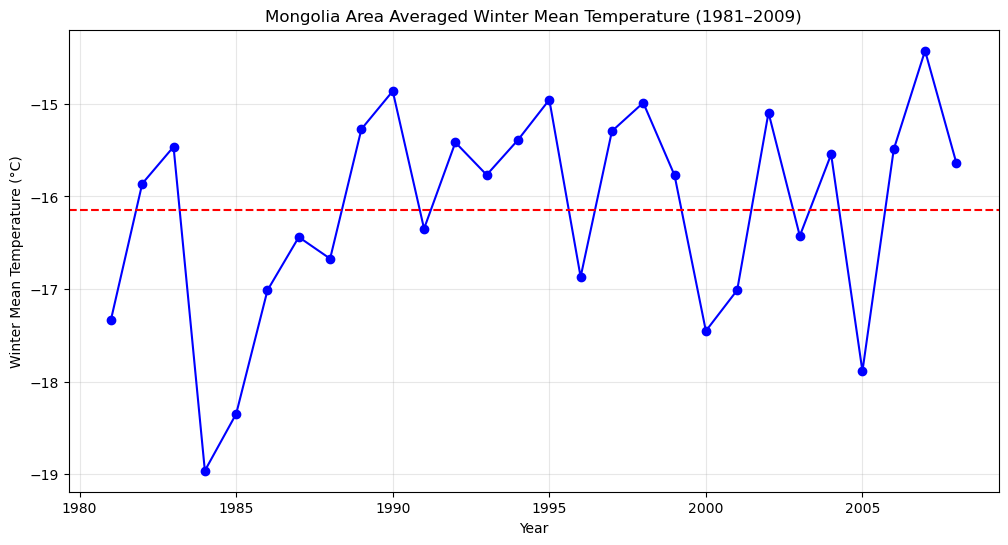

In [ ]:
winter = ds_era5.sel(time=ds_era5["time.month"].isin([11,12,1,2,3]))

winter["t2m_cel"] = winter["t2m"] - 273.15

winter_mean_temp = (winter["t2m_cel"].mean(dim=["latitude", "longitude"]).groupby("time.year").mean("time"))

dataframe_winter = (winter_mean_temp.compute().to_dataframe(name="winter_mean_temp_cel").reset_index())

clim_winter_mean = dataframe_winter["winter_mean_temp_cel"].mean()

plt.figure(figsize=(12, 6))
plt.plot(
    dataframe_winter["year"],
    dataframe_winter["winter_mean_temp_cel"],
    marker="o",
    linewidth=1.5,
    color="blue"
)
plt.axhline(
    clim_winter_mean,
    color="red",
    linestyle="--",
    label="Climatological Mean"
)

plt.xlabel("Year")
plt.ylabel("Winter Mean Temperature (°C)")
plt.title("Mongolia Area Averaged Winter Mean Temperature (1981–2009)")
plt.grid(alpha=0.3)
plt.show()

#### Interpretation

Winter mean temperatures show large interannual variability during the 1981-2008 baseline period, reflecting the harsh and variables conditions of the Mongolian winter and climate. While most winters cluster around the climatological mean, several years stand out as significantly harsher, indicating periods of severely low temperatures well before the 2009-2010 dzud.

Mean winter temperatures do not solely capture dzud severity, as the extreme impacts are most often driven not by individually cold temperatures, but rather a persistent time of low temperatures with poor timing for subsistence farmers. Despite this, this metric provides essential context for exploring whether or not the 2009-2010 winter represented a departure from typical historical climate norms and sets up for more detailed analysis of the historical baseline period for a better insight. 

## Summer 2009 Preconditioning Analysis

## Winter 2009-2010 Dzud Severity Analysis

## Localised Summer and Winter Analysis: Ulaanbaatar

## Seasonal Patterns and Compounding Risks

## Summary Statistics

## Conclusion and Next Steps